# Preprocessing Dataset #2

In [1]:

## Import the data
import pandas as pd


In [5]:
# 1. Load the datasets into Pandas dataframes
names2=['A1-Time','A2','A3','A4','A5','A6','A7','A8','A9','LABEL']
dataset2 = pd.read_csv('shuttle_trn.csv', index_col=False, names=names2, sep=' ', engine='python')
dataset2_test = pd.read_csv('shuttle_tst.csv', index_col=False, names=names2, sep=' ', engine='python')
print(dataset2.head)

<bound method NDFrame.head of        A1-Time  A2   A3  A4  A5  A6  A7  A8  A9  LABEL
0           50  21   77   0  28   0  27  48  22      2
1           55   0   92   0   0  26  36  92  56      4
2           53   0   82   0  52  -5  29  30   2      1
3           37   0   76   0  28  18  40  48   8      1
4           37   0   79   0  34 -26  43  46   2      1
...        ...  ..  ...  ..  ..  ..  ..  ..  ..    ...
43495       46   5   78   0  46   5  32  32   0      1
43496       37   0   79  -1  10   3  43  69  26      1
43497       48   0   78   3  46   0  30  32   2      1
43498       41   0   79   0  38 -25  38  40   2      1
43499       40  -3  100   0  38   0  61  62   2      1

[43500 rows x 10 columns]>



## Clean the data

Data is complete, i.e., no missing cells
Attributes are undefined, therefore all will be kept and be given the same weight


## Visulization

array([[<AxesSubplot:title={'center':'A1-Time'}>,
        <AxesSubplot:title={'center':'A2'}>,
        <AxesSubplot:title={'center':'A3'}>],
       [<AxesSubplot:title={'center':'A4'}>,
        <AxesSubplot:title={'center':'A5'}>,
        <AxesSubplot:title={'center':'A6'}>],
       [<AxesSubplot:title={'center':'A7'}>,
        <AxesSubplot:title={'center':'A8'}>,
        <AxesSubplot:title={'center':'A9'}>],
       [<AxesSubplot:title={'center':'LABEL'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

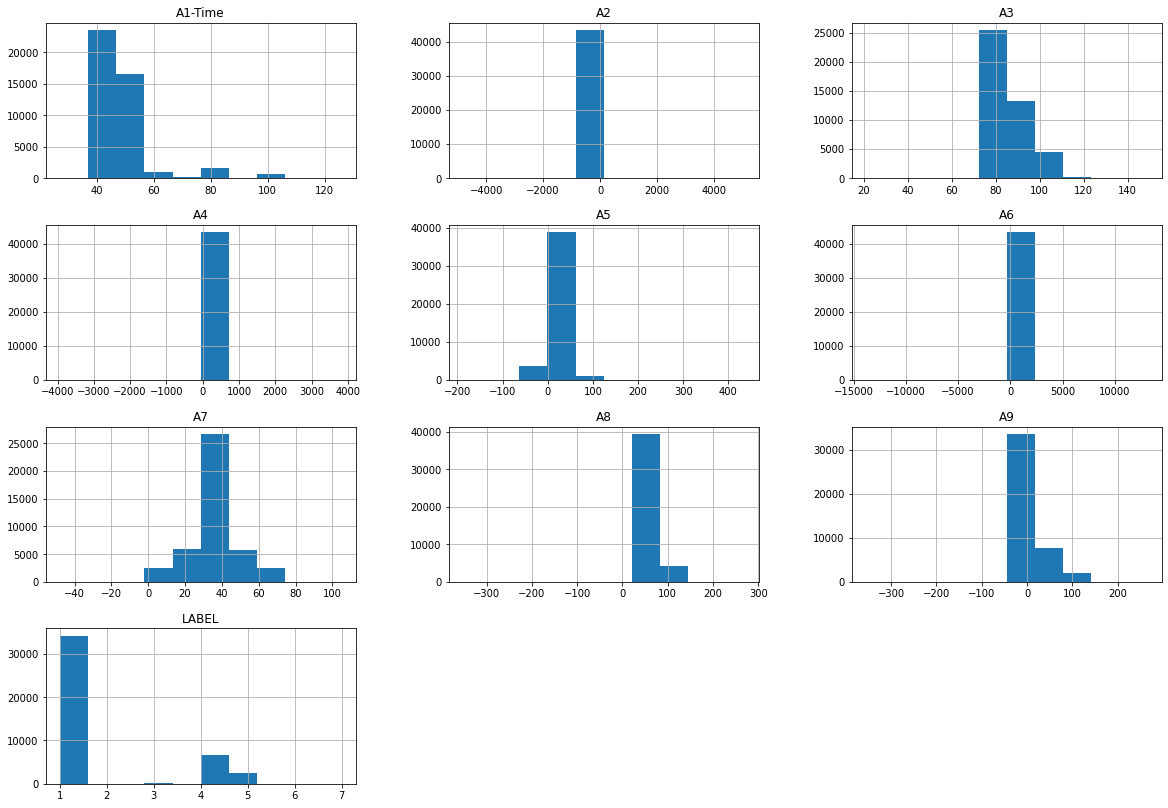

In [6]:
# Visualizing data to have a better idea of the data
# Plotting frequency of different attribute values since there are only 9 (+ 1 for assigned labels)
import matplotlib.pyplot as plt

# Visualize all numerical categories
dataset2.hist(figsize=(20, 14))

In [4]:
# Normalize
from sklearn import preprocessing

# Normalize age data
x = dataset2.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_dataset_2 = pd.DataFrame(x_scaled, columns=names2)

## One-hot coding
# No need for one-hot coding since all attributes and labels are numerical values